In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
import cv2 as cv
import os
import DarkArtefactRemoval as dca
import dullrazor as dr
import segmentation_and_preprocessing as sp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import gradcam_test as gc
import vanilla_backprop as vb

2024-04-26 01:02:08.297476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 01:02:12.019677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Loading Data

In [4]:
# Répertoire contenant les images
image_dir_train = 'Train/Train/'
image_dir_test = 'Test/Test/'

Train_path = image_dir_train

import glob
images_train = glob.glob(Train_path + '/*[0-9].jpg')
mask_img_train = glob.glob(Train_path + '/*seg.png')

images_with_mask = [ Train_path + mask_img_train[i].split('/')[-1].split('_seg')[0] + '.jpg' for i in range(len(mask_img_train))]
images_test = glob.glob(image_dir_test + '/*[0-9].jpg')
mask_img_test = glob.glob(image_dir_test + '/*seg.png')

#Lire le csv metadataTrain et metadataTest
metadataTrain = pd.read_csv('metadataTrain.csv')
metadataTest = pd.read_csv('metadataTest.csv')



In [5]:
# Checking if the number of images is right 
print('There are', len(images_train),  'train images')
print('There are', len(images_with_mask),  'train images with mask')
print('There are', len(mask_img_train),  'train masks')
print('There are', len(images_test),  'test images')
print('There are', len(mask_img_test),  'test masks')

There are 18998 train images
There are 1945 train images with mask
There are 1945 train masks
There are 6333 test images
There are 648 test masks


### Compute the segmentation mask for all the 20 000 images of the training set

In [ ]:
sp.compute_and_save_segmented_lesions(images_train[:len(images_train)//2], 'output_masks_train_set_1')

  0%|          | 0/9499 [00:00<?, ?it/s]

  0%|          | 39/9499 [00:04<16:35,  9.50it/s]


KeyboardInterrupt: 

In [ ]:
sp.compute_and_save_segmented_lesions(images_train[len(images_train)//2:], 'output_masks_train_set_1')

: 

In [ ]:
images_train_mask = glob.glob('output_masks_train_set_1' + '/*.png')
print(len(images_train_mask))

18998


# CNN

### Préparation des données

- Images carrées de 256x256
- Normalisation des images
- Augmentation des données

### Prepare data for CNN

In [6]:
X_train = glob.glob('output_masks_train_set_1/*.png')
X_train_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in X_train]

# Get the names and classes as pandas Series
names_series = metadataTrain["ID"].loc[metadataTrain["ID"].isin(X_train_names)]
classes_series = metadataTrain["CLASS"].loc[metadataTrain["ID"].isin(X_train_names)]

# Convert the pandas Series to lists
names_list = names_series.tolist()
classes_list = classes_series.tolist()

X_train_ordered = []
X_train_ordered_names = []
for i in range(0, len(names_list)):
    for j in range(0, len(X_train_names)):
        if names_list[i] in X_train_names[j]:
            X_train_ordered.append(X_train[j])
            X_train_ordered_names.append(X_train_names[j])

In [7]:

# Count the number of images in the second class
count = sum([1 for cls in classes_list if cls == 2])

# Divide the count by 2 to get the number of images to remove
num_to_remove = count // 2

# Create a new list to store the indices of the images to remove
indices_to_remove = []

# Iterate over the range of the length of X_train_ordered
for i in range(len(X_train_ordered)):
    # Check if the current image belongs to the second class and its index is less than the number of images to remove
    if classes_list[i] == 2 and len(indices_to_remove) < num_to_remove:
        # Append the index to the indices_to_remove list
        indices_to_remove.append(i)

# Create new lists for X_train_ordered, X_train_ordered_names, and classes_list by removing the indices stored in indices_to_remove
X_train_ordered_2 = [x for i, x in enumerate(X_train_ordered) if i not in indices_to_remove]
X_train_ordered_names_2 = [x for i, x in enumerate(X_train_ordered_names) if i not in indices_to_remove]
classes_list_2 = [x for i, x in enumerate(classes_list) if i not in indices_to_remove]
names_list_2 = [x for i, x in enumerate(names_list) if i not in indices_to_remove]


##### Train test split

In [8]:
X_train = [io.imread(x) for x in X_train_ordered]
X_train = np.array(X_train)
y_train = classes_list
y_train = np.array(y_train)
#----------------------------------
y_train = y_train - 1
#----------------------------------
print(X_train.shape)
print(y_train.shape)

#Créer la validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=50)

(18998, 256, 256, 3)
(18998,)


In [9]:
X_train_2 = [io.imread(x) for x in X_train_ordered_2]
X_train_2 = np.array(X_train_2)
y_train_2 = classes_list_2
y_train_2 = np.array(y_train_2)
#----------------------------------
y_train_2 = y_train_2 - 1
#----------------------------------
print(X_train_2.shape)
print(y_train_2.shape)

#Créer la validation set
X_train_2, X_val_2, y_trai_2, y_val_2 = train_test_split(X_train_2, y_train_2, test_size=0.2, random_state=50)

(14170, 256, 256, 3)
(14170,)


(array([2758., 7707., 1975.,    0.,  529., 1583.,    0.,  140.,  140.,
         366.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

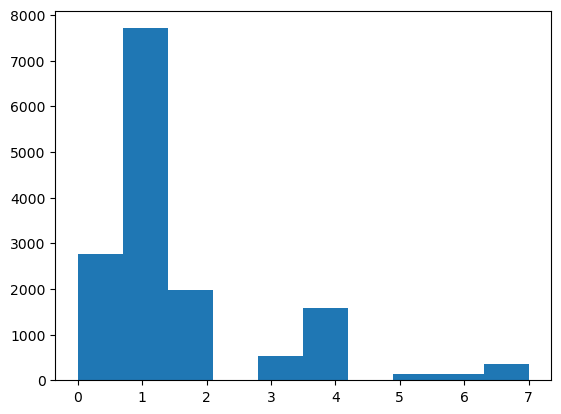

In [10]:
plt.hist(y_train)

(array([3391., 4829., 2492.,    0.,  650., 1968.,    0.,  179.,  190.,
         471.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

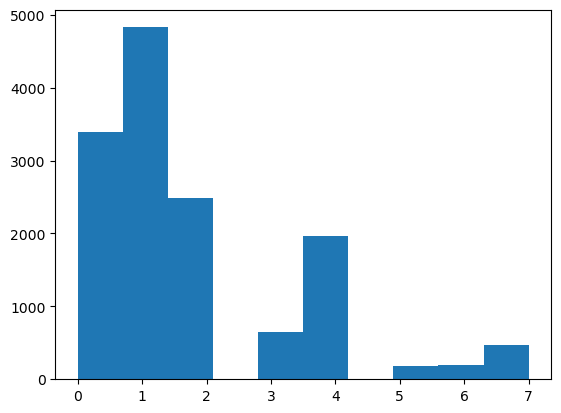

In [11]:
plt.hist(y_train_2)

# ATTENTION Y_train entre 1 et 8

# Modification j'ajoute -1 pour le passer entre 0 et 7 pour le CNN

# Ne pas oubliez de faire la démarche inverse après la prédiction

In [12]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Définir les transformations à appliquer aux images d'entraînement
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Créer le jeu de données de segmentation
train_dataset_1 = SegmentationDataset(X_train, y_train, transform=transform)
train_dataset_2 = SegmentationDataset(X_train_2, y_train_2, transform=transform)
train_dataset_3 = SegmentationDataset(X_train_2, y_train_2, transform=transform)


In [18]:
def cnn_accuracy(predict,labels):
  accuracy = (predict == labels).sum()/(labels.shape[0])
  return accuracy

def vector_to_class(x):
  y = torch.argmax(nn.Softmax(dim=1)(x),axis=1)
  return y

In [13]:
#MODEL 1
learning_rate_1 = 0.01
n_epochs_1 = 25
batch_size = 256
nb_classes = 8

nb_filters_1 = 32         # number of convolutional filters to use
kernel_size = (3, 3)    # convolution kernel size
pool_size = (2, 2)      # size of pooling area for max pooling

# --- Size of the successive layers
n_h_0 = nb_channels = 3 #3 channels for RGB
n_h_1 = nb_filters_1
n_h_2 = nb_filters_1
n_h_3 = nb_filters_1
n_h_4 = nb_filters_1
n_h_5 = nb_filters_1
n_h_6 = nb_filters_1


model_1 = torch.nn.Sequential(nn.Conv2d(in_channels=n_h_0, out_channels=n_h_1, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=n_h_1, out_channels=n_h_2, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_2, out_channels=n_h_3, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_3, out_channels=n_h_4, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_4, out_channels=n_h_5, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_5, out_channels=n_h_6, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            
                            nn.Flatten(),
                            nn.Linear(in_features = int(n_h_6 * 8* 8) , out_features = nb_classes))



train_loader_1 = torch.utils.data.DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
criterion_1 = torch.nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=learning_rate_1)

#print model summary
print(model_1)


device = torch.device("cuda:1" if torch.cuda.is_available() else "cuda:0" if torch.cuda.is_available() else "cpu")
print('device',device)
model_1 = model_1.to(device)

########## TRAINING 

train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs_1):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in enumerate(tqdm(train_loade_1)):

    # pass the samples through the network
    predict = model_1.forward(imgs.to(device))
    # apply loss function
    loss = criterion_1(predict, labels.to(device))
    # set the gradients back to 0
    optimizer_1.zero_grad()
    # backpropagation
    loss.backward()
    # parameter update
    optimizer_1.step()
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())

    if epoch % 1 == 0:
      torch.save(model_1.state_dict(), 'model_save/modele_epoch_{}.pth'.format(epoch))

  print('Epoch:{} Train Loss:{:.4f}'.format(epoch,train_loss/len(train_loader_1.dataset)))

  # calculate accuracy
  print('Accuracy:{:.4f}'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels))))

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (9): ReLU()
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (15): ReLU()
  (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (17): Flat

In [14]:
#MODEL 2 (less of class 2)
learning_rate_2 = 0.01
n_epochs_2 = 25
batch_size = 256
nb_classes = 8

nb_filters_2 = 32         # number of convolutional filters to use
kernel_size = (3, 3)    # convolution kernel size
pool_size = (2, 2)      # size of pooling area for max pooling

# --- Size of the successive layers
n_h_0 = nb_channels = 3 #3 channels for RGB
n_h_1 = nb_filters_2
n_h_2 = nb_filters_2
n_h_3 = nb_filters_2
n_h_4 = nb_filters_2
n_h_5 = nb_filters_2
n_h_6 = nb_filters_2


model_2 = torch.nn.Sequential(nn.Conv2d(in_channels=n_h_0, out_channels=n_h_1, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=n_h_1, out_channels=n_h_2, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_2, out_channels=n_h_3, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_3, out_channels=n_h_4, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_4, out_channels=n_h_5, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_5, out_channels=n_h_6, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            
                            nn.Flatten(),
                            nn.Linear(in_features = int(n_h_6 * 8* 8) , out_features = nb_classes))



train_loader_2 = torch.utils.data.DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)
criterion_2 = torch.nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=learning_rate_2)

#print model summary
print(model_2)


device = torch.device("cuda:1" if torch.cuda.is_available() else "cuda:0" if torch.cuda.is_available() else "cpu")
print('device',device)
model_2 = model_2.to(device)

########## TRAINING 

train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs_1):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in enumerate(tqdm(train_loader_2)):

    # pass the samples through the network
    predict = model_2.forward(imgs.to(device))
    # apply loss function
    loss = criterion_2(predict, labels.to(device))
    # set the gradients back to 0
    optimizer_2.zero_grad()
    # backpropagation
    loss.backward()
    # parameter update
    optimizer_2.step()
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())

    if epoch % 1 == 0:
      torch.save(model_2.state_dict(), 'model_save/modele_epoch_{}.pth'.format(epoch))

  print('Epoch:{} Train Loss:{:.4f}'.format(epoch,train_loss/len(train_loader_2.dataset)))

  # calculate accuracy
  print('Accuracy:{:.4f}'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels))))

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (9): ReLU()
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (15): ReLU()
  (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (17): Flat

In [15]:
#MODEL 3 (less of class 2)
learning_rate_3 = 0.01
n_epochs_3 = 15
batch_size = 256
nb_classes = 8

nb_filters_3 = 16         # number of convolutional filters to use
kernel_size = (3, 3)    # convolution kernel size
pool_size = (2, 2)      # size of pooling area for max pooling

# --- Size of the successive layers
n_h_0 = nb_channels = 3 #3 channels for RGB
n_h_1 = nb_filters_3
n_h_2 = nb_filters_3
n_h_3 = nb_filters_3
n_h_4 = nb_filters_3
n_h_5 = nb_filters_3
n_h_6 = nb_filters_3


model_3 = torch.nn.Sequential(nn.Conv2d(in_channels=n_h_0, out_channels=n_h_1, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=n_h_1, out_channels=n_h_2, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_2, out_channels=n_h_3, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_3, out_channels=n_h_4, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_4, out_channels=n_h_5, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            nn.Conv2d(in_channels=n_h_5, out_channels=n_h_6, kernel_size=kernel_size, stride=(1, 1), padding='same'),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = pool_size, stride= (2,2)),
                            
                            nn.Flatten(),
                            nn.Linear(in_features = int(n_h_6 * 8* 8) , out_features = nb_classes))



train_loader_3 = torch.utils.data.DataLoader(train_dataset_3, batch_size=batch_size, shuffle=True)
criterion_3 = torch.nn.CrossEntropyLoss()
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=learning_rate_3)

#print model summary
print(model_3)


device = torch.device("cuda:1" if torch.cuda.is_available() else "cuda:0" if torch.cuda.is_available() else "cpu")
print('device',device)
model_3 = model_3.to(device)

########## TRAINING 

train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs_1):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in enumerate(tqdm(train_loader_3)):

    # pass the samples through the network
    predict = model_3.forward(imgs.to(device))
    # apply loss function
    loss = criterion_3(predict, labels.to(device))
    # set the gradients back to 0
    optimizer_3.zero_grad()
    # backpropagation
    loss.backward()
    # parameter update
    optimizer_3.step()
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())

    if epoch % 1 == 0:
      torch.save(model_3.state_dict(), 'model_3_save/modele_epoch_{}.pth'.format(epoch))

  print('Epoch:{} Train Loss:{:.4f}'.format(epoch,train_loss/len(train_loader_3.dataset)))

  # calculate accuracy
  print('Accuracy:{:.4f}'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels))))

  3%|▎         | 2/60 [01:11<34:19, 35.50s/it]


KeyboardInterrupt: 

### Heatmap

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Predict the classes for the validation set

# Définir les transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Appliquer les transformations à X_val
X_val_transformed = [transform(img) for img in X_val]
X_val_transformed = torch.stack(X_val_transformed)

#load the model
model.load_state_dict(torch.load('model_save/modele_epoch_24.pth',map_location=torch.device('cpu')))
#device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cuda:0" if torch.cuda.is_available() else "cpu")
print('device',device)
model = model.to(device)


# Prédire les classes pour le jeu de validation
y_pred = model(X_val_transformed.to(device))
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.numpy()

print(y_pred)

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap from the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')

# Labels, title and ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(range(8))
plt.yticks(range(8))

# Add class names to the x and y axis labels
class_names = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7'] # replace with your class names
plt.xticks(range(8), class_names, rotation=45)
plt.yticks(range(8), class_names)

plt.show()


device cpu


: 

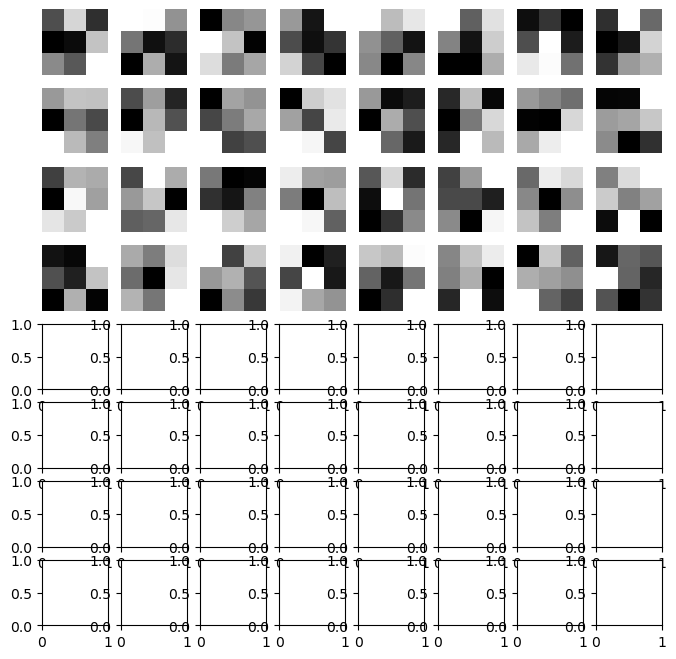

In [ ]:

# Extraire les poids des filtres de la première couche de convolution
filters = model[0].weight.data.cpu().numpy()

# Calculer le nombre de filtres dans la première couche de convolution
num_filters = filters.shape[0]

# Créer une grille de sous-tracés pour afficher les filtres
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Parcourir tous les filtres et les afficher dans la grille de sous-tracés
for i in range(num_filters):
    ax = axs[i // 8, i % 8]
    ax.imshow(filters[i, 0, :, :], cmap='gray')
    ax.axis('off')

plt.show()


In [ ]:
def image_vanilla_backprop(input_image, model, target_class):
    # Charger le modèle
    model = model.eval() # passer en mode évaluation

    # Définir l'image d'entrée

    #[batch_size, num_channels, height, width]
    input_tensor = torch.unsqueeze(torch.tensor(input_image), 0).permute(0, 3, 1, 2).float()

    # Définir la classe cible
    target_class = 1 # la classe cible

    # Créer une instance de VanillaBackprop
    vanilla_backprop = vb.VanillaBackprop(model)

    # Calculer les gradients avec Vanilla Backpropagation
    gradients = vanilla_backprop.generate_gradients(input_tensor, target_class)

    # Convertir les gradients en masque de pertinence
    masque = np.abs(gradients)
    masque = masque / np.max(masque) # normaliser entre 0 et 1

    # Afficher le masque de pertinence
    heatmap = masque.mean(axis=0)

    return heatmap

def plot_vanilla_backprop(liste_images,model):
    target_classes = [0,1,2,3,4,5,6,7]
    # Create subplots for heatmaps
    fig, axs = plt.subplots(len(liste_images), len(target_classes), figsize=(15, 10))

    # Iterate over images
    for i, image in enumerate(liste_images):
        # Iterate over target classes
        for j, target_class in enumerate(target_classes):
            # Compute heatmap for the image and target class
            heatmap = image_vanilla_backprop(image, model, target_class)
            
            # Display heatmap
            axs[i, j].imshow(heatmap, cmap='hot')
            axs[i, j].set_title(f'Target Class: {target_class}')
            axs[i, j].axis('off')

    # Display target classes in a row
    fig, ax = plt.subplots(1, len(target_classes), figsize=(15, 2))
    for j, target_class in enumerate(target_classes):
        ax[j].imshow(target_class_image)  # Replace with your own target class image
        ax[j].set_title(f'Target Class: {target_class}')
        ax[j].axis('off')

    plt.show()
    



In [ ]:
plot_vanilla_backprop(X_train[:5],model)

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models
from gradcam import GradCAM
from gradcam.utils import visualize_cam
from PIL import Image

# Charger une image à visualiser
img = Image.open('output_masks_train_set_1/ISIC_0000000.jpg_pred_mask.png')

# Transformer l'image en tenseur et l'ajouter à un lot
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Modifiez les moyennes et écarts-types en fonction de votre jeu de données
])
img_tensor = transform(img).unsqueeze(0).to(device)

# Définir la classe cible pour la visualisation
target_class = 3  # Remplacez par la classe cible souhaitée

# Créer un objet GradCAM pour la dernière couche de convolution du modèle
cam = GradCAM(model,model[-5])

# Calculer la carte de chaleur de grad-CAM pour la classe cible
with torch.no_grad():
    output = model(img_tensor)
    target_logits = output[:, target_class]
    target_logits = target_logits.long()
grayscale_cam = cam(img_tensor,target_logits)
grayscale_cam = grayscale_cam.squeeze().type(torch.uint8)
# Visualiser la carte de chaleur de grad-CAM superposée à l'image d'origine
visualization = visualize_cam(img_tensor, grayscale_cam)

# Afficher l'image
plt.imshow(visualization.cpu().numpy().transpose(1, 2, 0))
plt.show()


error: OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'operator()'


## Préparation de la detection

### Prepare data for predicting the test set

In [ ]:
X_test = glob.glob('output_masks_test_set/*.png')
X_test_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in X_test]

X_test = [io.imread(x) for x in X_test]
X_test = np.array(X_test)
print(X_test.shape)

: 

In [ ]:
predicted_classes = model.predict(X_test)

: 

In [ ]:
print(predicted_classes.shape)
print(predicted_classes)

predicted_classes_final = [np.argmax(predicted_classes[i]) for i in range(0, len(predicted_classes))]

print(predicted_classes_final)

: 

Ecrire les résultats predicted class dans un fichier csv de 2 colonnes avec 1 colonne avec le nom correspondant à la classe et 1 colonne correspondant à la classe prédite. Le séparateur est une virgule

In [ ]:
# Open the CSV file for writing
with open('SampleSubmission2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header row
    writer.writerow(['ID', 'CLASS'])

    # Write the predicted classes and image filenames to the CSV file
    for i in range(len(predicted_classes)):
        writer.writerow([X_test_names[i], predicted_classes_final[i]])

: 

: 